In [1]:
from sys import maxsize #para imprimir arrays completos
import numpy as np
import pandas as pd

from sklearn import preprocessing #para normalizar datos
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_validate
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV, ElasticNetCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn import metrics

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Para importar notebooks propias

In [2]:
import io, os, sys, types
from IPython import get_ipython
from nbformat import read
from IPython.core.interactiveshell import InteractiveShell

In [75]:
def find_notebook(fullname, path=None):
    """find a notebook, given its fully qualified name and an optional path

    This turns "foo.bar" into "foo/bar.ipynb"
    and tries turning "Foo_Bar" into "Foo Bar" if Foo_Bar
    does not exist.
    """
    name = fullname.rsplit('.', 1)[-1]
    if not path:
        path = ['']
    for d in path:
        nb_path = os.path.join(d, name + ".ipynb")
        if os.path.isfile(nb_path):
            return nb_path
        # let import Notebook_Name find "Notebook Name.ipynb"
        nb_path = nb_path.replace("_", " ")
        if os.path.isfile(nb_path):
            return nb_path

In [76]:
class NotebookLoader(object):
    """Module Loader for Jupyter Notebooks"""
    def __init__(self, path=None):
        self.shell = InteractiveShell.instance()
        self.path = path

    def load_module(self, fullname):
        """import a notebook as a module"""
        path = find_notebook(fullname, self.path)

        print ("importing Jupyter notebook from %s" % path)

        # load the notebook object
        with io.open(path, 'r', encoding='utf-8') as f:
            nb = read(f, 4)


        # create the module and add it to sys.modules
        # if name in sys.modules:
        #    return sys.modules[name]
        mod = types.ModuleType(fullname)
        mod.__file__ = path
        mod.__loader__ = self
        mod.__dict__['get_ipython'] = get_ipython
        sys.modules[fullname] = mod

        # extra work to ensure that magics that would affect the user_ns
        # actually affect the notebook module's ns
        save_user_ns = self.shell.user_ns
        self.shell.user_ns = mod.__dict__

        try:
          for cell in nb.cells:
            if cell.cell_type == 'code':
                # transform the input to executable Python
                code = self.shell.input_transformer_manager.transform_cell(cell.source)
                # run the code in themodule
                exec(code, mod.__dict__)
        finally:
            self.shell.user_ns = save_user_ns
        return mod

In [77]:
class NotebookFinder(object):
    """Module finder that locates Jupyter Notebooks"""
    def __init__(self):
        self.loaders = {}

    def find_module(self, fullname, path=None):
        nb_path = find_notebook(fullname, path)
        if not nb_path:
            return

        key = path
        if path:
            # lists aren't hashable
            key = os.path.sep.join(path)

        if key not in self.loaders:
            self.loaders[key] = NotebookLoader(path)
        return self.loaders[key]

In [78]:
sys.meta_path.append(NotebookFinder())

# Importamos bibliotecas propias

In [79]:
#luego de ejecutar las celdas anteriores, se puede importar la biblioteca propia
#si da errores, probar con hacer restart del kernel
import _02_Anexo_Func as funcs

# Levantamos el Dataframe

In [80]:
pathArchivoDataSet = 'mushrooms.csv' 
mushrooms = pd.read_csv(pathArchivoDataSet)

In [81]:
mushrooms.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   class                     8124 non-null   object
 1   cap-shape                 8124 non-null   object
 2   cap-surface               8124 non-null   object
 3   cap-color                 8124 non-null   object
 4   bruises                   8124 non-null   object
 5   odor                      8124 non-null   object
 6   gill-attachment           8124 non-null   object
 7   gill-spacing              8124 non-null   object
 8   gill-size                 8124 non-null   object
 9   gill-color                8124 non-null   object
 10  stalk-shape               8124 non-null   object
 11  stalk-root                8124 non-null   object
 12  stalk-surface-above-ring  8124 non-null   object
 13  stalk-surface-below-ring  8124 non-null   object
 14  stalk-color-above-ring  

##### Comprobamos que el data frame no tiene valores nulos

In [82]:
mushrooms.isna().sum()

class                       0
cap-shape                   0
cap-surface                 0
cap-color                   0
bruises                     0
odor                        0
gill-attachment             0
gill-spacing                0
gill-size                   0
gill-color                  0
stalk-shape                 0
stalk-root                  0
stalk-surface-above-ring    0
stalk-surface-below-ring    0
stalk-color-above-ring      0
stalk-color-below-ring      0
veil-type                   0
veil-color                  0
ring-number                 0
ring-type                   0
spore-print-color           0
population                  0
habitat                     0
dtype: int64

In [83]:
mushrooms.sample(10)

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
7990,p,k,y,n,f,f,f,c,n,b,...,s,p,p,p,w,o,e,w,v,p
1695,e,x,f,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g
2245,e,x,f,g,t,n,f,c,b,n,...,s,g,w,p,w,o,p,k,v,d
4303,p,f,f,g,f,f,f,c,b,g,...,k,p,n,p,w,o,l,h,y,d
5813,p,f,y,y,f,f,f,c,b,p,...,k,n,n,p,w,o,l,h,v,g
1529,e,x,s,w,f,n,f,w,b,n,...,f,w,w,p,w,o,e,k,a,g
6610,p,k,s,n,f,f,f,c,n,b,...,s,p,w,p,w,o,e,w,v,p
8099,e,k,f,w,f,n,f,w,b,w,...,k,w,w,p,w,t,p,w,s,g
2581,e,x,y,g,t,n,f,c,b,p,...,s,p,g,p,w,o,p,n,v,d
7150,p,f,y,e,f,f,f,c,n,b,...,s,w,p,p,w,o,e,w,v,p


In [84]:
mushrooms.columns

Index(['class', 'cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor',
       'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color',
       'stalk-shape', 'stalk-root', 'stalk-surface-above-ring',
       'stalk-surface-below-ring', 'stalk-color-above-ring',
       'stalk-color-below-ring', 'veil-type', 'veil-color', 'ring-number',
       'ring-type', 'spore-print-color', 'population', 'habitat'],
      dtype='object')

##### Modificamos todos los valores que contiene el dataframe, para hacerlos mas compresibles y legibles

In [85]:
funcs.getDescriptForEachColumns(mushrooms)

Este dataframe contiene por cada fila información acerca de  un hongo en particular. Vamos a generar un modelo para clasificar dichos hongos en si son comestibles o no.
La columna que dice si un hongo es comestible, o no, o sea nuestro target para el data set, es la primera ("edible"). Si vale 1 significa que sí es comestible.

In [86]:
mushrooms.head()

,edible,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,0,convex,smooth,brown,1,pungent,free,close,narrow,black,...,smooth,white,white,partial,white,one,pendant,black,scattered,urban
1,1,convex,smooth,yellow,1,almond,free,close,broad,black,...,smooth,white,white,partial,white,one,pendant,brown,numerous,grasses
2,1,bell,smooth,white,1,anise,free,close,broad,brown,...,smooth,white,white,partial,white,one,pendant,brown,numerous,meadows
3,0,convex,scaly,white,1,pungent,free,close,narrow,brown,...,smooth,white,white,partial,white,one,pendant,black,scattered,urban
4,1,convex,smooth,gray,0,none,free,crowded,broad,black,...,smooth,white,white,partial,white,one,evanescent,brown,abundant,grasses


##### Mostramos informacíón básica de todas las columnas del data frame

In [15]:
funcs.getInfoByColumn(mushrooms)

Información columna: edible 
---------------
count    8124.000000
mean        0.517971
std         0.499708
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: edible, dtype: float64
Show Unique  0 1

Información columna: cap-shape 
---------------
count       8124
unique         6
top       convex
freq        3656
Name: cap-shape, dtype: object
Show Unique  'convex' 'bell' 'sunken' 'flat' 'knobbed' 'conical'

Información columna: cap-surface 
---------------
count      8124
unique        4
top       scaly
freq       3244
Name: cap-surface, dtype: object
Show Unique  'smooth' 'scaly' 'fibrous' 'grooves'

Información columna: cap-color 
---------------
count      8124
unique       10
top       brown
freq       2284
Name: cap-color, dtype: object
Show Unique  'brown' 'yellow' 'white' 'gray' 'red' 'pink' 'buff' 'purple' 'cinnamon'
 'green',etc...

Información columna: bruises 
---------------
count    8124.000000
mean        0.415

###### Para obtener un poco más de información, imprimimos un histograma de todas las columnas

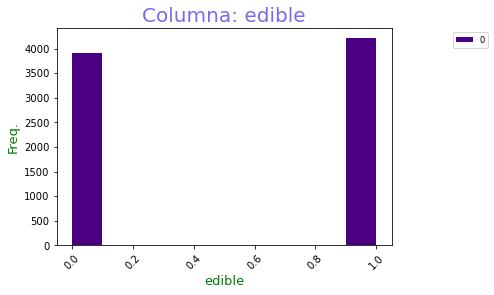

AxesSubplot(0.125,0.125;0.775x0.755)


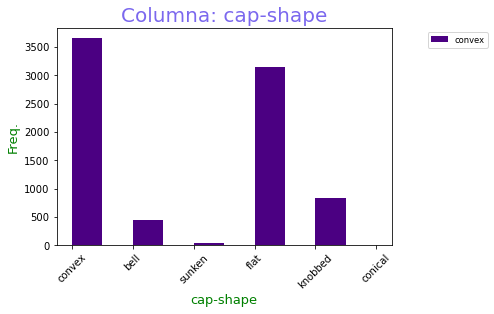

AxesSubplot(0.125,0.125;0.775x0.755)


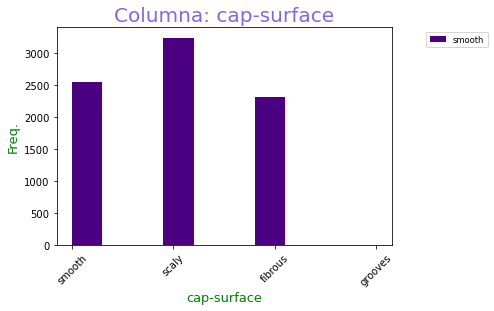

AxesSubplot(0.125,0.125;0.775x0.755)


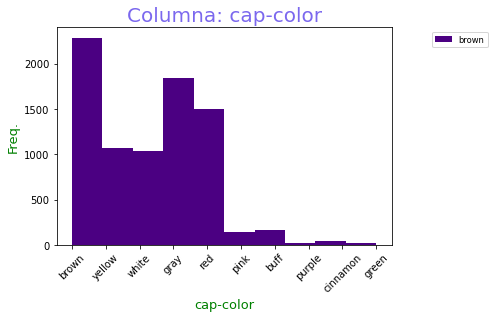

AxesSubplot(0.125,0.125;0.775x0.755)


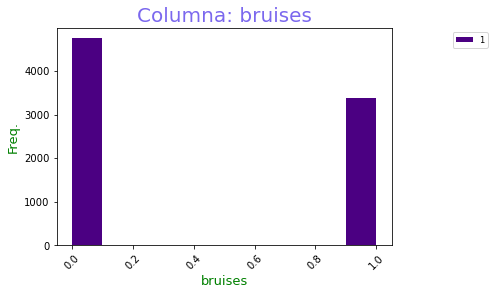

AxesSubplot(0.125,0.125;0.775x0.755)


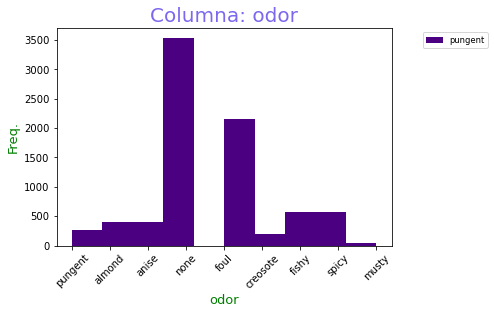

AxesSubplot(0.125,0.125;0.775x0.755)


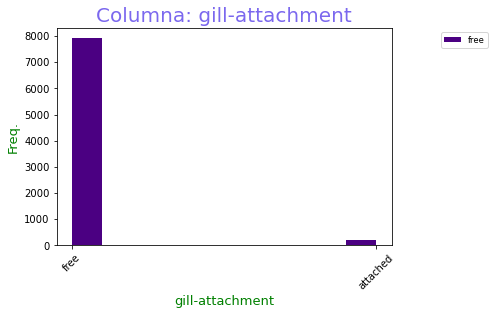

AxesSubplot(0.125,0.125;0.775x0.755)


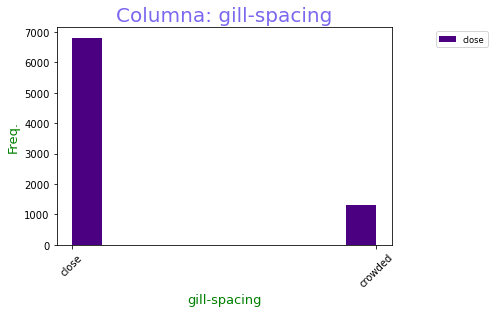

AxesSubplot(0.125,0.125;0.775x0.755)


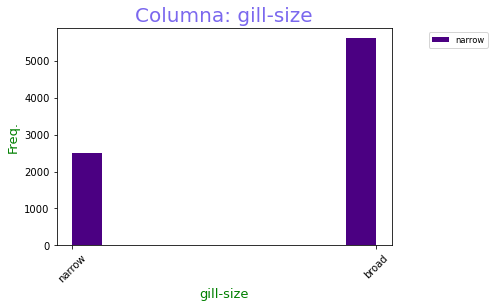

AxesSubplot(0.125,0.125;0.775x0.755)


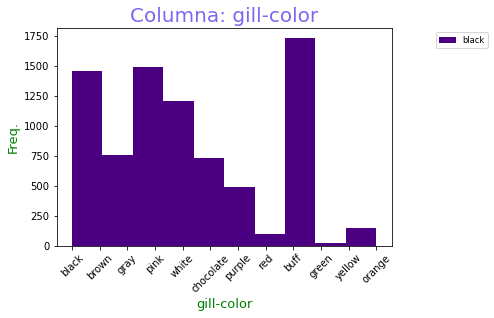

AxesSubplot(0.125,0.125;0.775x0.755)


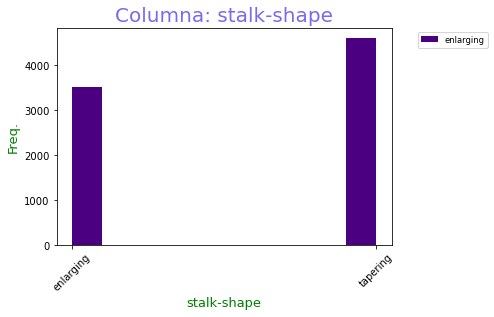

AxesSubplot(0.125,0.125;0.775x0.755)


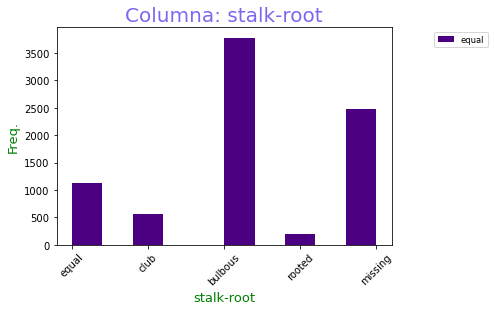

AxesSubplot(0.125,0.125;0.775x0.755)


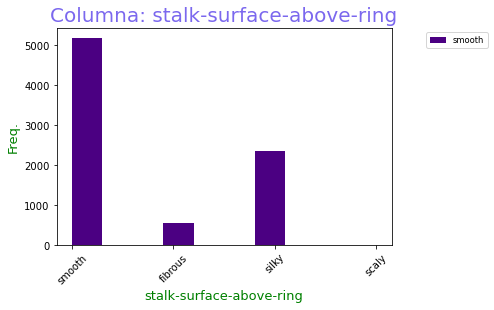

AxesSubplot(0.125,0.125;0.775x0.755)


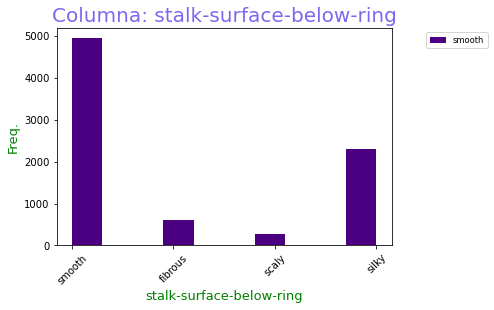

AxesSubplot(0.125,0.125;0.775x0.755)


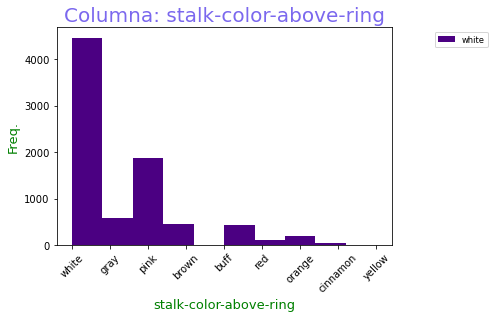

AxesSubplot(0.125,0.125;0.775x0.755)


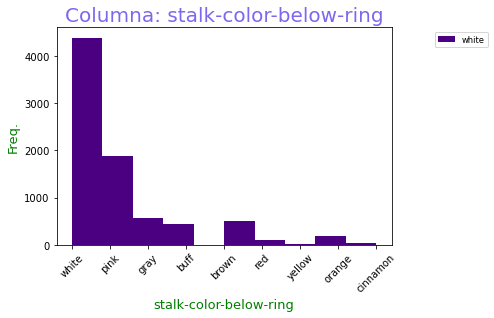

AxesSubplot(0.125,0.125;0.775x0.755)


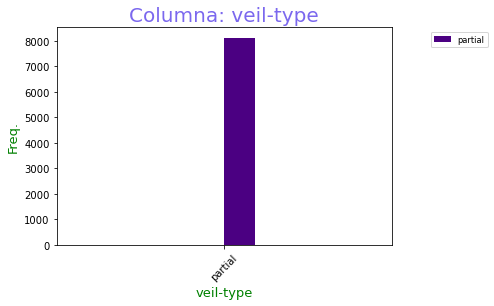

AxesSubplot(0.125,0.125;0.775x0.755)


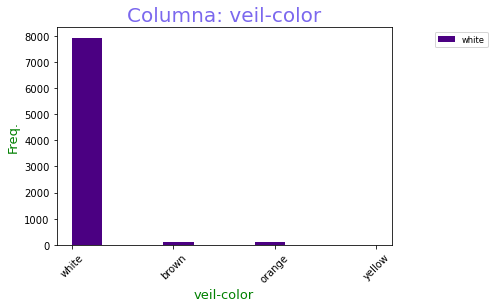

AxesSubplot(0.125,0.125;0.775x0.755)


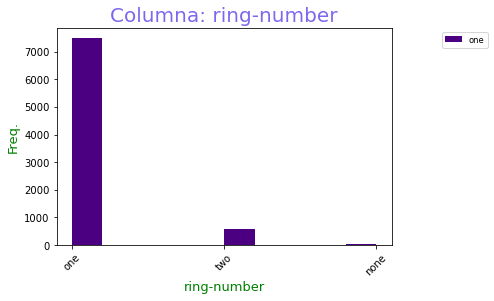

AxesSubplot(0.125,0.125;0.775x0.755)


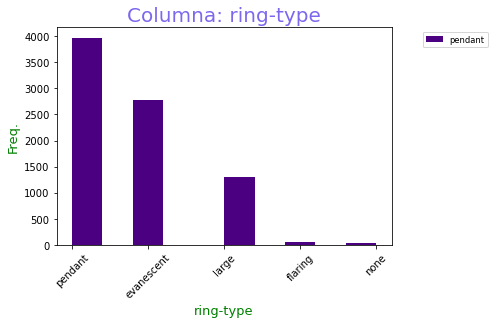

AxesSubplot(0.125,0.125;0.775x0.755)


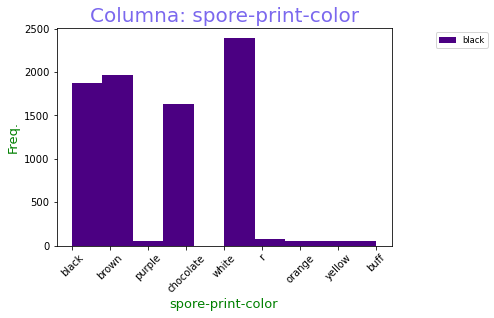

AxesSubplot(0.125,0.125;0.775x0.755)


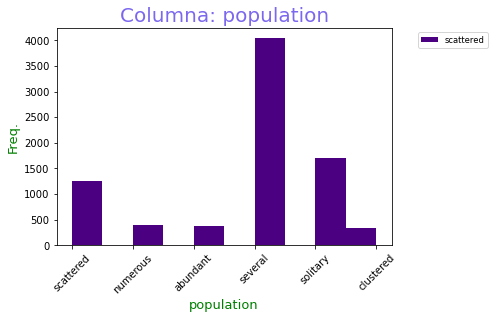

AxesSubplot(0.125,0.125;0.775x0.755)


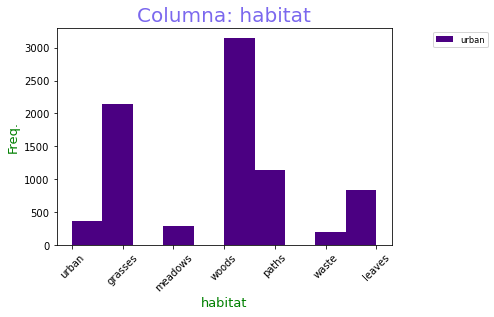

AxesSubplot(0.125,0.125;0.775x0.755)


In [16]:
funcs.getHistogramByColumn(mushrooms)

# Generación de dummies para variables categóricas

In [17]:
# Selección de columnas para Dummies
mushroomsdummies = pd.get_dummies(mushrooms, drop_first=True, columns=mushrooms.columns)
mushroomsdummies

,edible_1,cap-shape_conical,cap-shape_convex,cap-shape_flat,cap-shape_knobbed,cap-shape_sunken,cap-surface_grooves,cap-surface_scaly,cap-surface_smooth,cap-color_buff,...,population_numerous,population_scattered,population_several,population_solitary,habitat_leaves,habitat_meadows,habitat_paths,habitat_urban,habitat_waste,habitat_woods
0,0,0,1,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,1,0,0
1,1,0,1,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,1,0,...,1,0,0,0,0,1,0,0,0,0
3,0,0,1,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,1,0,0
4,1,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8119,1,0,0,0,1,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
8120,1,0,1,0,0,0,0,0,1,0,...,0,0,1,0,1,0,0,0,0,0
8121,1,0,0,1,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
8122,0,0,0,0,1,0,0,1,0,0,...,0,0,1,0,1,0,0,0,0,0


# Columnas luego de hacer Dummies
mushroomsdummies.columns

##### Mostramos información estadística para el data set, luego de generar los dummies

In [18]:
funcs.getStatisticForEachColumn(mushroomsdummies)

Statistics mesures from:edible_1
-----------------------------
STD:0.49970767884413053
VAR: 0.2497077642957887
Mean: 0.517971442639094

Statistics mesures from:cap-shape_conical
-----------------------------
STD:0.022185275504213193
VAR: 0.0004921864491978419
Mean: 0.0004923682914820286

Statistics mesures from:cap-shape_convex
-----------------------------
STD:0.49752681392757064
VAR: 0.2475329305769195
Mean: 0.4500246184145741

Statistics mesures from:cap-shape_flat
-----------------------------
STD:0.4873213968679901
VAR: 0.23748214384536911
Mean: 0.3879862136878385

Statistics mesures from:cap-shape_knobbed
-----------------------------
STD:0.30256201029582624
VAR: 0.09154377007425166
Mean: 0.1019202363367799

Statistics mesures from:cap-shape_sunken
-----------------------------
STD:0.06264115289778346
VAR: 0.003923914036363486
Mean: 0.003938946331856229

Statistics mesures from:cap-surface_grooves
-----------------------------
STD:0.02218527550421319
VAR: 0.0004921864491978418
Me

##### Verificamos la correlación entre las datos

In [46]:
matriz_corr = pd.DataFrame(mushroomsdummies.corr()['edible_1'])

In [51]:
matriz_corr

,edible_1
edible_1,1.000000
cap-shape_conical,-0.023007
cap-shape_convex,0.026886
cap-shape_flat,-0.018526
cap-shape_knobbed,-0.163565
...,...
habitat_meadows,0.138627
habitat_paths,-0.323346
habitat_urban,-0.112078
habitat_waste,0.150087


In [87]:
matriz_corr10=matriz_corr.abs().sort_values('edible_1',ascending= False).tail(10)

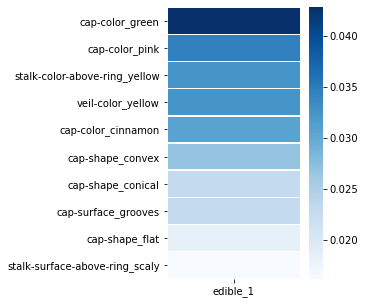

In [88]:
#funcs.plot_corr(matriz_corr, size=50)

plt.figure(figsize=(3, 5))
sns.heatmap(matriz_corr10,linewidths=.5,cmap="Blues")

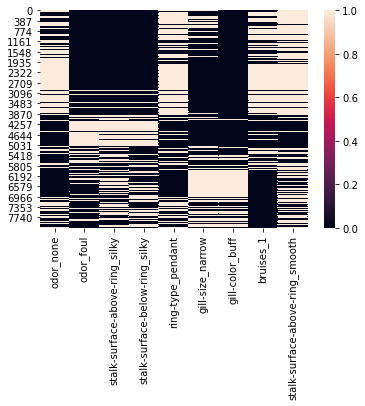

In [52]:
hm = sns.heatmap(mushroomsdummies[['odor_none','odor_foul','stalk-surface-above-ring_silky','stalk-surface-below-ring_silky','ring-type_pendant','gill-size_narrow','gill-color_buff','bruises_1','stalk-surface-above-ring_smooth']])

# Preparamos el data frame para la generación de los modelos

In [53]:
X = mushroomsdummies.drop(['edible_1'],axis=1)
X.head()

,cap-shape_conical,cap-shape_convex,cap-shape_flat,cap-shape_knobbed,cap-shape_sunken,cap-surface_grooves,cap-surface_scaly,cap-surface_smooth,cap-color_buff,cap-color_cinnamon,...,population_numerous,population_scattered,population_several,population_solitary,habitat_leaves,habitat_meadows,habitat_paths,habitat_urban,habitat_waste,habitat_woods
0,0,1,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,1,0,0
1,0,1,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,...,1,0,0,0,0,1,0,0,0,0
3,0,1,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,1,0,0
4,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [54]:
y = mushroomsdummies['edible_1']
y.sample(10)

2370    1
5625    0
6467    0
6487    0
2280    1
838     1
1424    1
6577    0
6824    0
5195    0
Name: edible_1, dtype: uint8

In [55]:
pd.Series(y).value_counts(normalize=True)

1    0.517971
0    0.482029
Name: edible_1, dtype: float64

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=12)

# Modelo KNN

### Dado que nuestro set de datos consiste en su totalidad de variables dummies, no necesitamos aplicar estandarización en ningún paso del análisis para este modelo. Los datos están todos en la misma escala

##### Buscamos el mejor hiperparámetro K, estandarizando los datos, buscando en un rango para K de 1 a 8. Con un KFold de 5 splits


In [57]:
df_scores = funcs.getScoresForHyperparameterK(quantityK=20, stepK= 1, model_X_train=X_train, model_y_train=y_train, \
                                                kFold_N_Splits=5, KFold_shuffle=True, useStandarization=False)

In [58]:
df_scores

,score_medio,score_std,n_neighbours,limite_inferior,limite_superior
0,1.000000,0.000000,1,1.000000,1.000000
1,1.000000,0.000000,2,1.000000,1.000000
2,1.000000,0.000000,3,1.000000,1.000000
3,0.999836,0.000328,4,0.999507,1.000164
4,1.000000,0.000000,5,1.000000,1.000000
5,1.000000,0.000000,6,1.000000,1.000000
6,0.999672,0.000656,7,0.999016,1.000328
7,0.999836,0.000328,8,0.999508,1.000164
8,0.999508,0.000984,9,0.998523,1.000492
9,0.999508,0.000984,10,0.998523,1.000492


##### Graficamos los resultados para ver los valores obtenidos

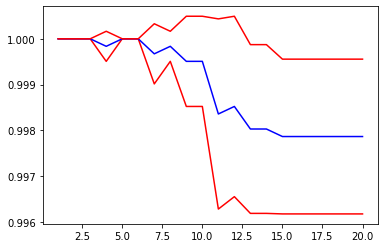

In [59]:
plt.plot(df_scores['n_neighbours'],df_scores['limite_inferior'],color='r')
plt.plot(df_scores['n_neighbours'],df_scores['score_medio'],color='b')
plt.plot(df_scores['n_neighbours'],df_scores['limite_superior'],color='r');

##### Mostramos los mejores de acuerdo a los datos

In [60]:
df_scores.loc[df_scores.score_medio == df_scores.score_medio.max()]

,score_medio,score_std,n_neighbours,limite_inferior,limite_superior
0,1.0,0.0,1,1.0,1.0
1,1.0,0.0,2,1.0,1.0
2,1.0,0.0,3,1.0,1.0
4,1.0,0.0,5,1.0,1.0
5,1.0,0.0,6,1.0,1.0


##### Seleccionamos uno

In [61]:
best_k = df_scores.loc[df_scores.score_medio == df_scores.score_medio.max(),'n_neighbours'].values
best_k = best_k[0]
print('Seleccionado K =', best_k)

Seleccionado K = 1


##### Obtenido el valor para K, procedemos a ver como se comporta el modelo con datos no utilizados en la búsqueda del hiperparámetro K

In [62]:
#obtenemos las predicciones del modelo, utilizando el mejor K obtenido
y_pred = funcs.getKNNPredictions(X_train, y_train, X_test, best_k, useStandarization=False)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')


##### Analizamos los resultados con la matriz de confusión

array([[ 979,    0],
       [   0, 1052]], dtype=int64)

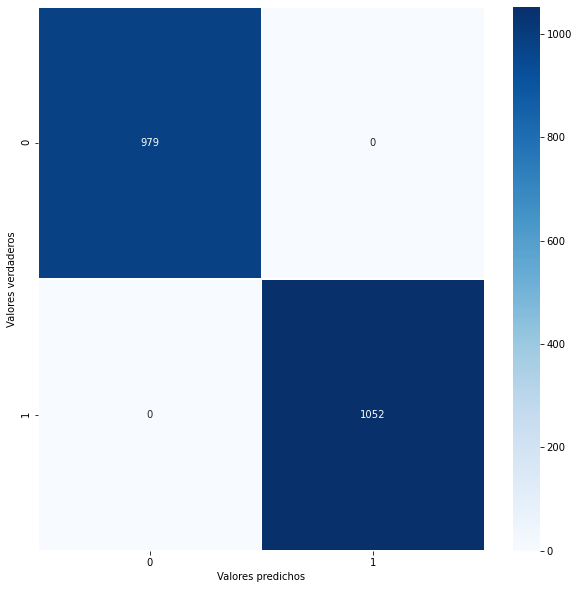

In [63]:
funcs.getConfusionMatrix(y_test, y_pred)

# Modelo Regresion Logistica


##### Buscamos el mejor hiperparametro C para la regresión

In [64]:
posiblesValoresHiperparametroC = np.linspace(0.0001, 20, 100)

In [65]:
df_scores_rl = funcs.getScoresForHyperparameterC(valoresPosiblesC=posiblesValoresHiperparametroC, model_X_train=X_train, \
                                                 model_y_train=y_train, kFold_N_Splits=5, KFold_shuffle=True, \
                                                 useStandarization=False)

C:\Users\agaravano\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\agaravano\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\agaravano\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\agaravano\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\agaravano\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\l

C:\Users\agaravano\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\agaravano\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\agaravano\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\agaravano\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\agaravano\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\l

C:\Users\agaravano\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\agaravano\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\agaravano\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\agaravano\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\agaravano\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\l

C:\Users\agaravano\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\agaravano\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\agaravano\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\agaravano\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\agaravano\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\l

##### Graficamos los resultados para ver los valores obtenidos

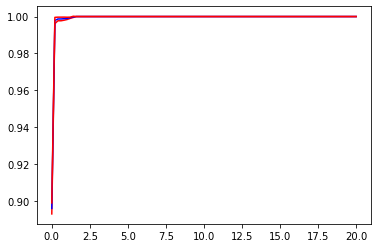

In [66]:
plt.plot(df_scores_rl['C'],df_scores_rl['limite_inferior'],color='r')
plt.plot(df_scores_rl['C'],df_scores_rl['score_medio'],color='b')
plt.plot(df_scores_rl['C'],df_scores_rl['limite_superior'],color='r');

##### Mostramos los mejores de acuerdo a los datos

In [67]:
df_scores_rl.loc[df_scores_rl.score_medio == df_scores_rl.score_medio.max()]

,score_medio,score_std,C,limite_inferior,limite_superior
8,1.0,0.0,1.616254,1.0,1.0
9,1.0,0.0,1.818273,1.0,1.0
10,1.0,0.0,2.020292,1.0,1.0
11,1.0,0.0,2.222311,1.0,1.0
12,1.0,0.0,2.424330,1.0,1.0
...,...,...,...,...,...
95,1.0,0.0,19.191923,1.0,1.0
96,1.0,0.0,19.393942,1.0,1.0
97,1.0,0.0,19.595962,1.0,1.0
98,1.0,0.0,19.797981,1.0,1.0


##### Seleccionamos uno

In [68]:
best_C = df_scores_rl.loc[df_scores_rl.score_medio == df_scores_rl.score_medio.max(),'C'].values
best_C = best_C[0]
print('Seleccionado C =', best_C)

Seleccionado C = 1.6162535353535354


##### Obtenido el valor para C, procedemos a ver como se comporta el modelo con datos no utilizados en la búsqueda del hiperparámetro C

In [69]:
#obtenemos las predicciones del modelo, utilizando el mejor K obtenido
y_pred_lr = funcs.getLogisticRegressionPredictions(X_train, y_train, X_test, best_C, useStandarization=False)

LogisticRegression(C=1.6162535353535354, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


##### Analizamos los resultados con la matriz de confusión

array([[ 979,    0],
       [   0, 1052]], dtype=int64)

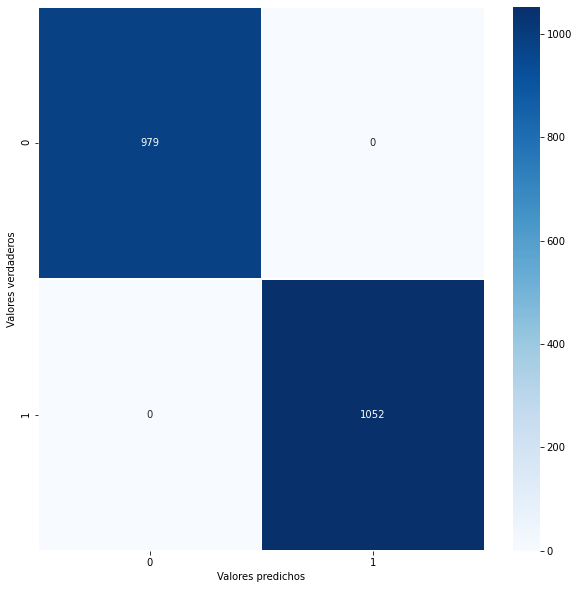

In [70]:
funcs.getConfusionMatrix(y_test, y_pred_lr)

# Modelo Naive Bayes

##### Utilizamos un modelo Bernouille Naive Bayes, ya que todas las variables son discretas (son todas dummies que derivan de variables categoricas), que solo adoptan dos valores 1 o 0

In [71]:
y_pred_NB = funcs.getBernoulliNaiveBayesPredictions(X_train, y_train, X_test)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)


array([[ 878,  101],
       [   2, 1050]], dtype=int64)

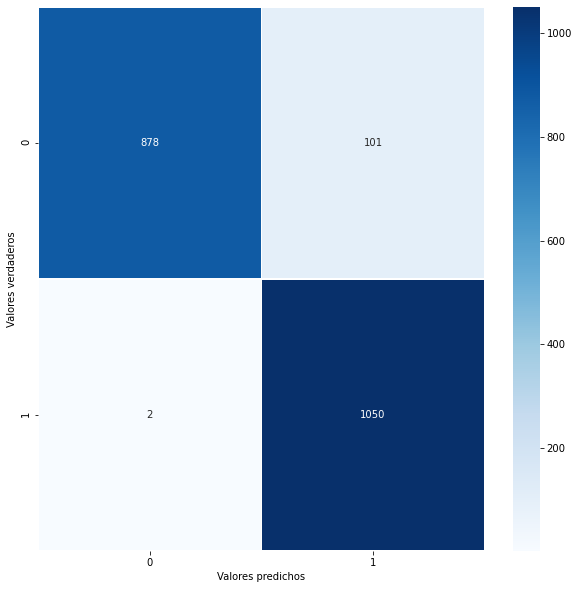

In [72]:
funcs.getConfusionMatrix(y_test, y_pred_NB)

In [73]:
# Podemos calcular manualmente la exactitud de nuestro modelo...

(851 + 1045) / len(y_pred)

0.9335302806499262

In [74]:
# ... o computarla utilizando el método del accuracy score

accuracy_score(y_test, y_pred)

1.0